# Setup

In [18]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from datacleaner import autoclean, autoclean_cv
from statsmodels.tools.tools import add_constant

# Plotting
from statsmodels.api import qqplot

# Tests
import scipy as sp
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity


# Experimental 
from sklearn.experimental import enable_halving_search_cv # noqa

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Performace indicators and Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import HalvingRandomSearchCV
from mlxtend.evaluate import lift_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

# Interpretation
import shap
from corrGroups import corrGrouper

# API
import datarobot as dr

# # Utilities
from sklearn import set_config
set_config(display='diagram')
pd.set_option('display.max_columns', None)

In [13]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    droppedVars = []
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            droppedVars.append(X.columns[variables[maxloc]])
            del variables[maxloc]
            dropped = True

    return droppedVars

# Outputs the columns that need to be dropped
def to_drop(dataset, corr_threshold):
    # Create correlation matrix
    corr_matrix = dataset.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

    # Find index of feature columns with correlation greater than corr_threshold
    drop = [column for column in upper.columns if any(
        upper[column] > corr_threshold)]

    return drop

In [14]:
# Useful Functions
def model_performance(X0, X1, Y0, Y1, model):
    Y0_predict = model.predict(X0)
    Y1_predict = model.predict(X1)

    Y0_hat = model.predict_proba(X0)[:, 1]
    Y1_hat = model.predict_proba(X1)[:, 1]

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1, Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0, Y0_predict))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1, Y1_predict))
    print('-------------------------')

# RFE for with n_features for the model
def best_features(model, n_features, exog, endog):
    estimator = model
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    selector.fit(exog, endog)
    n_feature_rankings = 1
    best_features = exog.columns[selector.ranking_ <= n_feature_rankings]
    return best_features

In [15]:
# outlier  highlighter
def highlight_quantile_outliers(dataset, outlier_identifier=10**10-1, upper=0.99, lower=0.01):
    data = dataset.copy()
    for column in data:
        q_upper = data[column].quantile(upper)
        q_lower = data[column].quantile(lower)
        data[column] = data[column].apply(
            lambda x: outlier_identifier if (x > q_upper or x < q_lower) and (x!=-outlier_identifier) else x)
    return data

# preprocessing pipeline
def processing_data(X, encoder, imputer, outlier_imputer=None, dtype='train'):
    categorical = X.select_dtypes('object')
    numeric_values = X.select_dtypes(exclude='object')

    if dtype == 'train':
        ordinal = pd.DataFrame(encoder.fit_transform(categorical.fillna('Missing')),
                               columns=categorical.columns, index=categorical.index)
        numeric = pd.DataFrame(imputer.fit_transform(numeric_values), numeric_values.index,
                               numeric_values.columns)
        # Exclude outliers
        if type(outlier_imputer) != type(None):
            outlier_data = highlight_quantile_outliers(numeric, outlier_imputer.missing_values)
            numeric = pd.DataFrame(outlier_imputer.fit_transform(outlier_data), 
                                   numeric.index, numeric.columns)
        
    elif dtype == 'test':
        ordinal = pd.DataFrame(encoder.transform(categorical.fillna('Missing')),
                               columns=categorical.columns, index=categorical.index)
        numeric = pd.DataFrame(imputer.transform(numeric_values), numeric_values.index,
                               numeric_values.columns)
    else:
        return X
    X_precessed = pd.concat([numeric, ordinal], axis=1)
    return X_precessed

# **Data Preview**

In [16]:
# Importing the data
dataset = pd.read_csv('./data/email_marketing.csv')

# Setting up variables
target = 'RESPONSE_FLAG'
X = dataset.drop(target, axis=1)
y = dataset[target]

# Splittind data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Performing some preprocessing
X_train, X_test = autoclean_cv(X_train, X_test, copy=True)
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

# Setting up dataframe reference
data_train = pd.concat([y_train, X_train], axis=1)
data_test = pd.concat([y_test, X_test], axis=1)
data = data_train

In [7]:
# Taking a look at the data
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20550 entries, 2893 to 23654
Columns: 127 entries, RESPONSE_FLAG to STATE_CD
dtypes: float64(126), int64(1)
memory usage: 20.1 MB


RESPONSE_FLAG  const  ARV17_MINUS_ARV16  AXM4970T  AXM4971T  AXM5030T  \
2893              0    1.0            10749.0       8.0      17.0    3597.0   
8807              0    1.0             7204.0      12.0      21.0   20681.0   

      AXM5032T  AXM5130T  AXM5131T  AXM5930T  AXM5931T  AXM5932T  AXM5933T  \
2893   96075.0   97765.0   97765.0   17674.0   28152.0     171.0     187.0   
8807   16844.0   45637.0   45637.0    9606.0   27405.0      64.0      99.0   

      AXM8131T  BKRPT_RCV_SCORE_VALUE  BRC4003T  BRC4012T  BRC4016T  BRC4970T  \
2893       0.0                  427.0       1.0      16.0       5.0      11.0   
8807       0.0                  184.0       3.0      14.0      21.0      12.0   

      BRC4971T  BRC5030T  BRC5032T  BRC5130T  BRC5131T  BRC5230T  BRC5231T  \
2893      19.0   12681.0   24086.0   25776.0   25776.0    3230.0    2682.0   
8807      21.0   22702.0    7453.0   36246.0   36246.0    2153.0    1861.0   

      BRC5530T  BRC5531T  BRC8131T  CUNSAGE_V1  CUNSBAL_V1  CUNSINQ_V1  \
2893    5218.0    4941.0       0.0         0.0         0.0         0.0   
8807    3323.0    3226.0       0.0         0.0         0.0         0.0   

      CUS02_V2  CUS07_REV120_V1  DEM05  HOMEEQUITY_HEQ09  SCR02  SCR16  \
2893       0.0              0.0    1.0               0.0  764.0  649.0   
8807       0.0              0.0   35.0           50000.0  776.0  637.0   

      SMARTV40_AAL01  SMARTV40_AAL18  SMARTV40_AAL19  SMARTV40_AAL24  \
2893            18.0        278898.0        305203.0           136.0   
8807            18.0         95874.0        105720.0           332.0   

      SMARTV40_AAL25  SMARTV40_AAL27  SMARTV40_AAL60  SMARTV40_AAL61  \
2893             2.0            47.0          2912.0             9.0   
8807             1.0            64.0          1706.0            15.0   

      SMARTV40_AAL63  SMARTV40_AAL66  SMARTV40_AAU13  SMARTV40_ABK01  \
2893             6.0             3.0            14.0             6.0   
8807            10.0             4.0            18.0             8.0   

      SMARTV40_ABK05  SMARTV40_ABK18  SMARTV40_ABK19  SMARTV40_ABK21  \
2893             5.0            78.0         11186.0            93.0   
8807             7.0            99.0         15496.0           103.0   

      SMARTV40_ABK22  SMARTV40_ABK23  SMARTV40_ABK33  SMARTV40_ABK35  \
2893           136.0             2.0             5.0             0.0   
8807           143.0             1.0             7.0             1.0   

      SMARTV40_AHD11  SMARTV40_AHD31  SMARTV40_AHI22  SMARTV40_AHI46  \
2893             0.0             0.0             0.0             0.0   
8807             0.0             0.0             0.0             0.0   

      SMARTV40_AHI90  SMARTV40_AIN17  SMARTV40_AIQ01  SMARTV40_AIQ02  \
2893             0.0         81744.0             1.0             1.0   
8807             0.0         12270.0             2.0             2.0   

      SMARTV40_AIQ04  SMARTV40_AIQ05  SMARTV40_AIQ07  SMARTV40_ALN03  \
2893             1.0             1.0             1.0             0.0   
8807             2.0             2.0             0.0             0.0   

      SMARTV40_ALN09  SMARTV40_ALN12  SMARTV40_ALN13  SMARTV40_ALN14  \
2893             0.0             0.0             0.0             0.0   
8807             0.0             0.0             0.0             0.0   

      SMARTV40_AMG13  SMARTV40_AMG14  SMARTV40_AMG31  SMARTV40_AMG41  \
2893            21.0          1106.0        181133.0            24.0   
8807             5.0             0.0             0.0             0.0   

      SMARTV40_AMG46  SMARTV40_APR01  SMARTV40_APR04  SMARTV40_APR24  \
2893        181133.0             0.0             0.0             0.0   
8807             0.0             0.0             0.0             0.0   

      SMARTV40_APR30  SMARTV40_APR35  SMARTV40_APR45  SMARTV40_ART02  \
2893             0.0             0.0             0.0             0.0   
8807             0.0             0.0             0.0             3.0   

    

In [8]:
# Create the Correlation pairs table
corr = data.corr()
corr = corr.mask(np.tril(np.ones(corr.shape)).astype('bool'))
corr = corr.unstack().reset_index().dropna()
corr.columns = ['Var1', 'Var2', 'Corr']
corr['AbsCorr'] = corr['Corr'].abs()
corr = corr.sort_values('AbsCorr', ascending=False)

# Target correlation pairs
resposeCorrs = corr[(corr['Var1'] == 'RESPONSE_FLAG') | (corr['Var2'] == 'RESPONSE_FLAG')]

In [9]:
resposeCorrs[:15]

Var1           Var2      Corr   AbsCorr
12192  SMARTV40_ARV16  RESPONSE_FLAG  0.166884  0.166884
7112   SMARTV40_ABK33  RESPONSE_FLAG  0.157975  0.157975
13081  SMARTV40_ARV34  RESPONSE_FLAG  0.146902  0.146902
6350   SMARTV40_ABK05  RESPONSE_FLAG  0.142712  0.142712
2540         BRC5030T  RESPONSE_FLAG  0.141098  0.141098
12319  SMARTV40_ARV17  RESPONSE_FLAG  0.140012  0.140012
2667         BRC5032T  RESPONSE_FLAG  0.139688  0.139688
6223   SMARTV40_ABK01  RESPONSE_FLAG  0.131736  0.131736
11938  SMARTV40_ARV05  RESPONSE_FLAG  0.119472  0.119472
5715   SMARTV40_AAL61  RESPONSE_FLAG  0.114899  0.114899
12065  SMARTV40_ARV15  RESPONSE_FLAG  0.109194  0.109194
2794         BRC5130T  RESPONSE_FLAG  0.108522  0.108522
2921         BRC5131T  RESPONSE_FLAG  0.105436  0.105436
11811  SMARTV40_ARV03  RESPONSE_FLAG  0.098202  0.098202
3556         BRC8131T  RESPONSE_FLAG -0.097402  0.097402

In [10]:
groups = corrGrouper(data)

groupsTable = []
for group in groups:
    groupTable = dict.fromkeys(group, 0)
    for value in group:
        corrWithTarget = resposeCorrs[(resposeCorrs['Var1'] == value) | (resposeCorrs['Var2'] == value)]['Corr']
        groupTable[value] = round(float(corrWithTarget), 4)
    groupsTable.append(groupTable)

# Correlation of similar columns with the target
groupsTable

[{'AXM5131T': 0.06, 'AXM5130T': 0.0623},
 {'SMARTV40_AIQ05': 0.094, 'SMARTV40_AIQ04': 0.0937},
 {'BRC5131T': 0.1054, 'BRC5130T': 0.1085},
 {'BRC5531T': -0.0241, 'BRC5530T': -0.024},
 {'SMARTV40_ART07': 0.0412, 'SMARTV40_ART02': 0.0397},
 {'SMARTV40_AAL18': 0.0096, 'SMARTV40_AAL19': 0.0156}]

In [13]:
# Deciding on similar columns to drop
drop_corrMatrix = to_drop(data, corr_threshold=0.95)
drop_corrMatrix

['AXM5131T',
 'BRC5131T',
 'BRC5531T',
 'SMARTV40_AAL19',
 'SMARTV40_AIQ05',
 'SMARTV40_ART07']

In [29]:
# Columns to drop using vif 
drop_vif = calculate_vif_(data, thresh=5.0)

invalid value encountered in double_scalars


dropping 'const' at index: 1


invalid value encountered in double_scalars


dropping 'AXM5131T' at index: 7
dropping 'SCR16' at index: 35
dropping 'SMARTV40_ABK21' at index: 50
dropping 'BRC5130T' at index: 20
dropping 'SMARTV40_AIQ04' at index: 61
dropping 'SMARTV40_CRM01' at index: 104
dropping 'SMARTV40_ARV18' at index: 92
dropping 'BRC5530T' at index: 23
dropping 'SMARTV40_CRN01' at index: 102
dropping 'SMARTV40_ABK18' at index: 46
dropping 'BRC4971T' at index: 17
dropping 'SCR02' at index: 31
dropping 'SMARTV40_CMG05' at index: 98
dropping 'SMARTV40_ABK05' at index: 43
dropping 'SMARTV40_ARV01' at index: 81
dropping 'SMARTV40_ARV17' at index: 85
dropping 'SMARTV40_AAL19' at index: 33
dropping 'BRC5230T' at index: 20
dropping 'AXM4971T' at index: 3
dropping 'SMARTV40_AAU19' at index: 102
dropping 'SMARTV40_AAL61' at index: 35
dropping 'SMARTV40_ARV22' at index: 81
dropping 'BRC4970T' at index: 15
dropping 'SMARTV40_ARV05' at index: 77
dropping 'SMARTV40_ARV16' at index: 78
dropping 'SMARTV40_ART07' at index: 70
dropping 'SMARTV40_AAL27' at index: 32
droppi

In [30]:
# np.array(drop_vif)

array(['const', 'AXM5131T', 'SCR16', 'SMARTV40_ABK21', 'BRC5130T',
       'SMARTV40_AIQ04', 'SMARTV40_CRM01', 'SMARTV40_ARV18', 'BRC5530T',
       'SMARTV40_CRN01', 'SMARTV40_ABK18', 'BRC4971T', 'SCR02',
       'SMARTV40_CMG05', 'SMARTV40_ABK05', 'SMARTV40_ARV01',
       'SMARTV40_ARV17', 'SMARTV40_AAL19', 'BRC5230T', 'AXM4971T',
       'SMARTV40_AAU19', 'SMARTV40_AAL61', 'SMARTV40_ARV22', 'BRC4970T',
       'SMARTV40_ARV05', 'SMARTV40_ARV16', 'SMARTV40_ART07',
       'SMARTV40_AAL27', 'SMARTV40_ABK01', 'SMARTV40_AIQ02',
       'SMARTV40_AAL60', 'SMARTV40_AAL01', 'SMARTV40_ARV34',
       'SMARTV40_CRT06', 'AXM5930T', 'BRC5531T', 'SMARTV40_AAU20',
       'AXM5130T', 'AXM5933T', 'SMARTV40_ABK33', 'SMARTV40_AAL18',
       'SMARTV40_AAL24', 'BRC5131T', 'AXM4970T', 'SMARTV40_ART33',
       'BRC4012T', 'SMARTV40_ARV03', 'SMARTV40_ABK22', 'SMARTV40_AAL63',
       'SMARTV40_ABK19', 'BRC4016T', 'DEM03', 'SMARTV40_ARV23',
       'SMARTV40_APR04', 'SMARTV40_CMG04', 'SMARTV40_ART24',
       'SMART

In [31]:
drop = ['const', 'AXM5131T', 'SCR16', 'SMARTV40_ABK21', 'BRC5130T',
       'SMARTV40_AIQ04', 'SMARTV40_CRM01', 'SMARTV40_ARV18', 'BRC5530T',
       'SMARTV40_CRN01', 'SMARTV40_ABK18', 'BRC4971T', 'SCR02',
       'SMARTV40_CMG05', 'SMARTV40_ABK05', 'SMARTV40_ARV01',
       'SMARTV40_ARV17', 'SMARTV40_AAL19', 'BRC5230T', 'AXM4971T',
       'SMARTV40_AAU19', 'SMARTV40_AAL61', 'SMARTV40_ARV22', 'BRC4970T',
       'SMARTV40_ARV05', 'SMARTV40_ARV16', 'SMARTV40_ART07',
       'SMARTV40_AAL27', 'SMARTV40_ABK01', 'SMARTV40_AIQ02',
       'SMARTV40_AAL60', 'SMARTV40_AAL01', 'SMARTV40_ARV34',
       'SMARTV40_CRT06', 'AXM5930T', 'BRC5531T', 'SMARTV40_AAU20',
       'AXM5130T', 'AXM5933T', 'SMARTV40_ABK33', 'SMARTV40_AAL18',
       'SMARTV40_AAL24', 'BRC5131T', 'AXM4970T', 'SMARTV40_ART33',
       'BRC4012T', 'SMARTV40_ARV03', 'SMARTV40_ABK22', 'SMARTV40_AAL63',
       'SMARTV40_ABK19', 'BRC4016T', 'DEM03', 'SMARTV40_ARV23',
       'SMARTV40_APR04', 'SMARTV40_CMG04', 'SMARTV40_ART24',
       'SMARTV40_CRT01', 'BKRPT_RCV_SCORE_VALUE', 'BRC5032T',
       'SMARTV40_AAU22', 'SMARTV40_AIQ01', 'SMARTV40_AMG14', 'AXM5931T',
       'BRC5231T', 'AXM5032T']

data_trimmed = data.drop(drop, axis=1)
data_trimmed.shape

(20550, 62)

Data Before


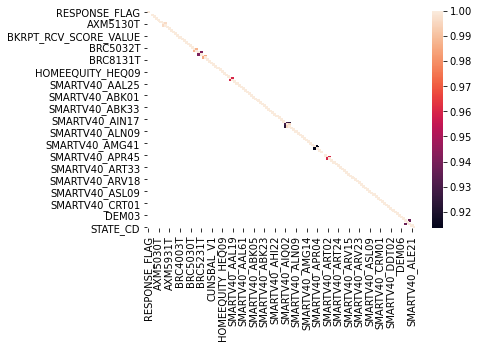

Data After


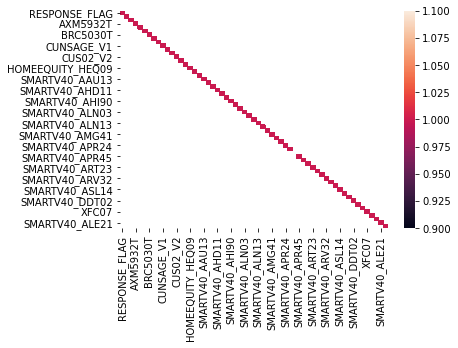

In [15]:
print('Data Before')
sns.heatmap(data.corr().abs()[data.corr().abs() > 0.9])
plt.show()

print('Data After')
sns.heatmap(data_trimmed.corr().abs()[data_trimmed.corr().abs() > 0.9])
plt.show()

In [16]:
# Create the Correlation pairs table
corr = data_trimmed.corr()
corr = corr.mask(np.tril(np.ones(corr.shape)).astype('bool'))
corr = corr.unstack().reset_index().dropna()
corr.columns = ['Var1', 'Var2', 'Corr']
corr['AbsCorr'] = corr['Corr'].abs()
corr = corr.sort_values('AbsCorr', ascending=False)

# Target correlation pairs
resposeCorrs = corr[(corr['Var1'] == 'RESPONSE_FLAG') | (corr['Var2'] == 'RESPONSE_FLAG')]

In [17]:
target = 'RESPONSE_FLAG'
mainFeatures = list(set(list(resposeCorrs['Var1'][:15]) + list(resposeCorrs['Var2'][:15])))
mainFeatures.remove(target)
mainColumns = mainFeatures + [target]
resposeCorrs[:15]

Var1           Var2      Corr   AbsCorr
354         BRC5030T  RESPONSE_FLAG  0.141098  0.141098
2537  SMARTV40_ARV15  RESPONSE_FLAG  0.109194  0.109194
472         BRC8131T  RESPONSE_FLAG -0.097402  0.097402
1475  SMARTV40_AIQ05  RESPONSE_FLAG  0.094037  0.094037
236         AXM8131T  RESPONSE_FLAG -0.079356  0.079356
1121  SMARTV40_ABK23  RESPONSE_FLAG -0.076943  0.076943
118         AXM5931T  RESPONSE_FLAG  0.074091  0.074091
59          AXM5030T  RESPONSE_FLAG  0.070948  0.070948
590       CUNSBAL_V1  RESPONSE_FLAG  0.064652  0.064652
1593  SMARTV40_ALN03  RESPONSE_FLAG  0.063237  0.063237
2950  SMARTV40_DDT01  RESPONSE_FLAG  0.061876  0.061876
413         BRC5231T  RESPONSE_FLAG -0.059778  0.059778
2360  SMARTV40_ART17  RESPONSE_FLAG  0.059300  0.059300
2655  SMARTV40_ARV32  RESPONSE_FLAG -0.057010  0.057010
531       CUNSAGE_V1  RESPONSE_FLAG  0.048584  0.048584

In [18]:
data_trimmed.head(2)

RESPONSE_FLAG  AXM5030T  AXM5931T  AXM5932T  AXM8131T  BRC4003T  \
2893              0    3597.0   28152.0     171.0       0.0       1.0   
8807              0   20681.0   27405.0      64.0       0.0       3.0   

      BRC5030T  BRC5231T  BRC8131T  CUNSAGE_V1  CUNSBAL_V1  CUNSINQ_V1  \
2893   12681.0    2682.0       0.0         0.0         0.0         0.0   
8807   22702.0    1861.0       0.0         0.0         0.0         0.0   

      CUS02_V2  CUS07_REV120_V1  DEM05  HOMEEQUITY_HEQ09  SMARTV40_AAL25  \
2893       0.0              0.0    1.0               0.0             2.0   
8807       0.0              0.0   35.0           50000.0             1.0   

      SMARTV40_AAL66  SMARTV40_AAU13  SMARTV40_ABK23  SMARTV40_ABK35  \
2893             3.0            14.0             2.0             0.0   
8807             4.0            18.0             1.0             1.0   

      SMARTV40_AHD11  SMARTV40_AHD31  SMARTV40_AHI46  SMARTV40_AHI90  \
2893             0.0             0.0             0.0             0.0   
8807             0.0             0.0             0.0             0.0   

      SMARTV40_AIQ05  SMARTV40_AIQ07  SMARTV40_ALN03  SMARTV40_ALN09  \
2893             1.0             1.0             0.0             0.0   
8807             2.0             0.0             0.0             0.0   

      SMARTV40_ALN12  SMARTV40_ALN13  SMARTV40_AMG13  SMARTV40_AMG31  \
2893             0.0             0.0            21.0        181133.0   
8807             0.0             0.0             5.0             0.0   

      SMARTV40_AMG41  SMARTV40_AMG46  SMARTV40_APR01  SMARTV40_APR24  \
2893            24.0        181133.0             0.0             0.0   
8807             0.0             0.0             0.0             0.0   

      SMARTV40_APR30  SMARTV40_APR35  SMARTV40_APR45  SMARTV40_ART17  \
2893             0.0             0.0             0.0           700.0   
8807             0.0             0.0             0.0          7900.0   

      SMARTV40_ART18  SMARTV40_ART23  SMARTV40_ARV15  SMARTV40_ARV31  \
2893             0.0            27.0             3.0            46.0   
8807            23.0            25.0             5.0           143.0   

      SMARTV40_ARV32  SMARTV40_ASL01  SMARTV40_ASL09  SMARTV40_ASL14  \
2893             2.0             3.0         35696.0           382.0   
8807             1.0             0.0             0.0             0.0   

      SMARTV40_ASL37  SMARTV40_DDT01  SMARTV40_DDT02  SMARTV40_DDT18  XFC06  \
2893             9.0            76.0            76.0             0.0    2.0   
8807             0.0            43.0             0.0             0.0    2.0   

      XFC07  DEM06  DEM08  SMARTV40_ALE21  STATE_CD  
2893    0.0    1.0    4.0             0.0      16.0  
8807    0.0    0.0    3.0             0.0       6.0

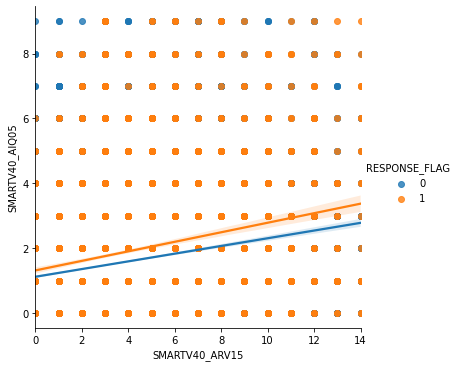

In [19]:
sns.lmplot(data=data_trimmed[mainColumns], x="SMARTV40_ARV15", y="SMARTV40_AIQ05",hue="RESPONSE_FLAG")
plt.show()

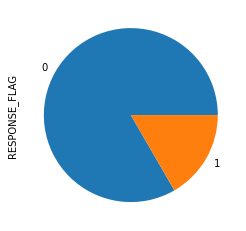

In [20]:
data_trimmed['RESPONSE_FLAG'].value_counts().plot(kind='pie')
plt.show()

# **Logistic regression**

In [32]:
X_train_trimmed = X_train.drop(drop, axis=1)
X_test_trimmed = X_test.drop(drop, axis=1)

# Scaling Data
scaler = preprocessing.StandardScaler()
X0 = pd.DataFrame(scaler.fit_transform(X_train_trimmed), index=X_train_trimmed.index, 
                  columns=X_train_trimmed.columns)
X1 = pd.DataFrame(scaler.transform(X_test_trimmed), index=X_test_trimmed.index, 
                  columns=X_test_trimmed.columns)

In [39]:
LM2 = LogisticRegression(random_state=42).fit(X0,y_train)

model_performance(X0, X1, y_train, y_test, LM2)


ROC AUC Train 0.678
ROC AUC Test 0.663
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     17128
           1       0.47      0.02      0.04      3422

    accuracy                           0.83     20550
   macro avg       0.65      0.51      0.47     20550
weighted avg       0.77      0.83      0.76     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      5722
           1       0.39      0.07      0.11      1129

    accuracy                           0.83      6851
   macro avg       0.61      0.52      0.51      6851
weighted avg       0.77      0.83      0.77      6851

-------------------------


In [41]:
logit_best = best_features(LogisticRegression(random_state=42), n_features=37, exog=X0, endog=y_train)
logit_best

Index(['ARV17_MINUS_ARV16', 'AXM8131T', 'BRC5030T', 'BRC8131T', 'CUNSAGE_V1',
       'CUNSBAL_V1', 'CUNSINQ_V1', 'CUS02_V2', 'DEM05', 'SMARTV40_AAL25',
       'SMARTV40_ABK23', 'SMARTV40_ABK35', 'SMARTV40_AHD31', 'SMARTV40_AHI22',
       'SMARTV40_AHI46', 'SMARTV40_AHI90', 'SMARTV40_AIN17', 'SMARTV40_AIQ05',
       'SMARTV40_AIQ07', 'SMARTV40_ALN03', 'SMARTV40_ALN12', 'SMARTV40_ALN13',
       'SMARTV40_AMG13', 'SMARTV40_AMG46', 'SMARTV40_APR30', 'SMARTV40_ART17',
       'SMARTV40_ART18', 'SMARTV40_ART23', 'SMARTV40_ARV15', 'SMARTV40_ASL01',
       'SMARTV40_ASL37', 'SMARTV40_DDT01', 'SMARTV40_DDT18', 'XFC06', 'DEM06',
       'DEM08', 'STATE_CD'],
      dtype='object')

In [42]:
LM3 = LogisticRegression(random_state=42).fit(X0[logit_best],y_train)
model_performance(X0[logit_best], X1[logit_best], y_train, y_test, LM3)


ROC AUC Train 0.677
ROC AUC Test 0.662
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     17128
           1       0.50      0.02      0.04      3422

    accuracy                           0.83     20550
   macro avg       0.67      0.51      0.48     20550
weighted avg       0.78      0.83      0.76     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      5722
           1       0.38      0.06      0.11      1129

    accuracy                           0.83      6851
   macro avg       0.61      0.52      0.51      6851
weighted avg       0.76      0.83      0.77      6851

-------------------------


In [46]:
param_logit={'C':np.linspace(0,10,30),
             'class_weight': ['balanced', None],
             "penalty": ['l1', 'l2'],
             'tol':np.linspace(0.00005,0.0009,30)
             }
gridsearch = GridSearchCV(estimator=LogisticRegression(random_state=42),
                        param_grid=param_logit,
                        cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

gridsearch.fit(X0[logit_best], y_train)
best_model_params = gridsearch.best_params_

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2110 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 4224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6300 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 8998 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 12002 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 15616 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 18000 out of 18000 | elapsed:  6.9min finished


In [47]:
best_model_params

{'C': 0.3448275862068966,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'tol': 5e-05}

In [43]:
logit_best_model_params = {'C': 0.3448275862068966,
                           'class_weight': 'balanced',
                           'penalty': 'l2',
                           'tol': 5e-05}

LM4 = LogisticRegression(
    random_state=42, **logit_best_model_params).fit(X0[logit_best], y_train)
model_performance((X0[logit_best]), X1[logit_best], y_train, y_test, LM4)


ROC AUC Train 0.678
ROC AUC Test 0.662
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.89      0.64      0.75     17128
           1       0.26      0.61      0.36      3422

    accuracy                           0.64     20550
   macro avg       0.58      0.63      0.56     20550
weighted avg       0.79      0.64      0.68     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      5722
           1       0.24      0.63      0.35      1129

    accuracy                           0.61      6851
   macro avg       0.57      0.62      0.53      6851
weighted avg       0.78      0.61      0.66      6851

-------------------------


best_features_logit:  Index(['ARV17_MINUS_ARV16', 'AXM8131T', 'BRC5030T', 'BRC8131T', 'CUNSAGE_V1',
       'CUNSBAL_V1', 'CUNSINQ_V1', 'CUS02_V2', 'DEM05', 'SMARTV40_AAL25',
       'SMARTV40_ABK23', 'SMARTV40_ABK35', 'SMARTV40_AHD31', 'SMARTV40_AHI22',
       'SMARTV40_AHI46', 'SMARTV40_AHI90', 'SMARTV40_AIN17', 'SMARTV40_AIQ05',
       'SMARTV40_AIQ07', 'SMARTV40_ALN03', 'SMARTV40_ALN12', 'SMARTV40_ALN13',
       'SMARTV40_AMG13', 'SMARTV40_AMG46', 'SMARTV40_APR30', 'SMARTV40_ART17',
       'SMARTV40_ART18', 'SMARTV40_ART23', 'SMARTV40_ARV15', 'SMARTV40_ASL01',
       'SMARTV40_ASL37', 'SMARTV40_DDT01', 'SMARTV40_DDT18', 'XFC06', 'DEM06',
       'DEM08', 'STATE_CD'],
      dtype='object') 



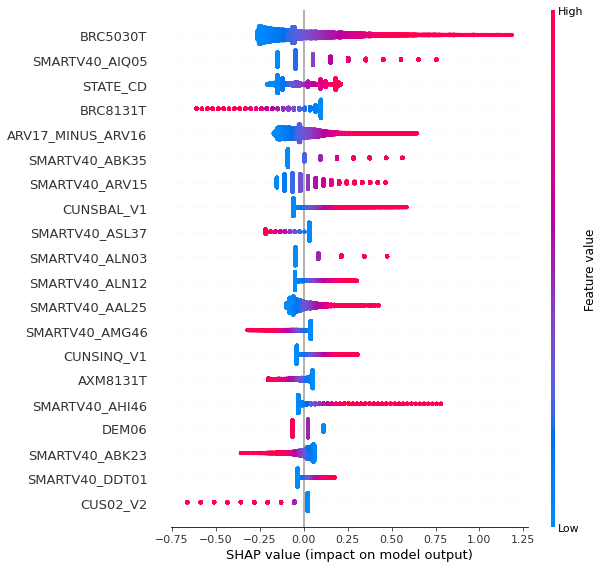

In [44]:
print('best_features_logit: ', logit_best, '\n')
shap_values = shap.LinearExplainer(LM4, X_train_scaled[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best])

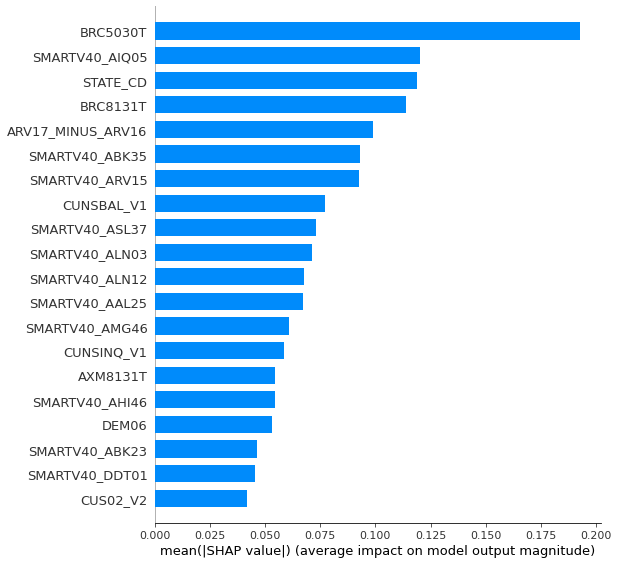

In [45]:
# Explaining the model with SHAP
shap_values = shap.LinearExplainer(LM4, X_train_scaled[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best], plot_type="bar")

# Logit Alternative

In [46]:
LR = LogisticRegression(random_state=42).fit(X_train_scaled.drop(drop, axis=1), y_train)
model_performance(X_train_scaled.drop(drop, axis=1), X_test_scaled.drop(drop, axis=1), y_train, y_test, LR)


ROC AUC Train 0.678
ROC AUC Test 0.663
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     17128
           1       0.47      0.02      0.04      3422

    accuracy                           0.83     20550
   macro avg       0.65      0.51      0.47     20550
weighted avg       0.77      0.83      0.76     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      5722
           1       0.39      0.07      0.11      1129

    accuracy                           0.83      6851
   macro avg       0.61      0.52      0.51      6851
weighted avg       0.77      0.83      0.77      6851

-------------------------


# **Decision Tree**

In [75]:
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

In [55]:
DT1 = DecisionTreeClassifier(random_state=42)
DT1.fit(X_train,y_train)
model_performance(X_train, X_test, y_train, y_test, DT1)


ROC AUC Train 1.0
ROC AUC Test 0.556
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17128
           1       1.00      1.00      1.00      3422

    accuracy                           1.00     20550
   macro avg       1.00      1.00      1.00     20550
weighted avg       1.00      1.00      1.00     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5722
           1       0.24      0.30      0.27      1129

    accuracy                           0.73      6851
   macro avg       0.55      0.56      0.55      6851
weighted avg       0.75      0.73      0.74      6851

-------------------------


In [101]:
param_dt={'max_depth': range(2,9),
          'max_leaf_nodes': range(8, 15),
          'class_weight': ['balanced', None],
          'min_samples_split': range(1, 3),
          'min_samples_leaf': range(1, 2),
          'max_features': [75]
          }
dtGrid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_dt,
                  scoring="neg_log_loss", cv=5, n_jobs= -1, verbose=1)

dtGrid.fit(X_train,y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 973 out of 980 | elapsed:   51.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   51.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(2, 9), 'max_features': [75],
                         'max_leaf_nodes': range(8, 15),
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(1, 3)},
             scoring='neg_log_loss', verbose=1)

In [102]:
dt_best_params = dtGrid.best_params_

print('Best Params:', dtGrid.best_params_)
print('LogLoss Score:', round(-(dtGrid.best_score_), 3))

Best Params: {'class_weight': None, 'max_depth': 5, 'max_features': 75, 'max_leaf_nodes': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}
LogLoss Score: 0.412


In [103]:
DT2 = DecisionTreeClassifier(random_state=42, **dt_best_params)
DT2.fit(X_train,y_train)
model_performance(X_train, X_test, y_train, y_test, DT2)


ROC AUC Train 0.725
ROC AUC Test 0.699
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17128
           1       0.52      0.11      0.19      3422

    accuracy                           0.83     20550
   macro avg       0.68      0.55      0.55     20550
weighted avg       0.79      0.83      0.79     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5722
           1       0.51      0.13      0.20      1129

    accuracy                           0.84      6851
   macro avg       0.68      0.55      0.55      6851
weighted avg       0.79      0.84      0.79      6851

-------------------------


In [104]:
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(
    estimator=DT2,X=X_all,y=y_all,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.7


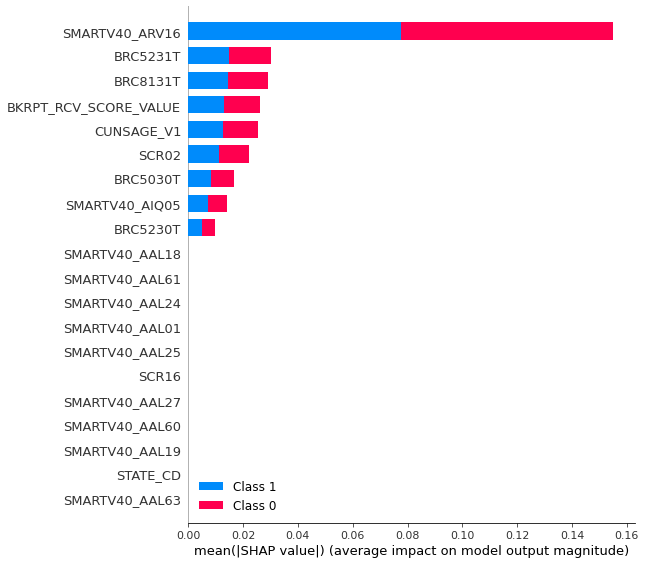

In [110]:
shap_values = shap.TreeExplainer(DT2, X_all).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

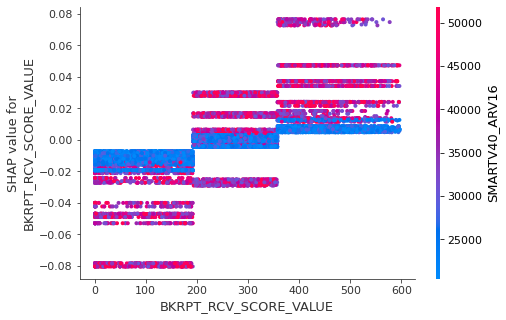

In [108]:
shap.dependence_plot('BKRPT_RCV_SCORE_VALUE', shap_values[0], X_train)

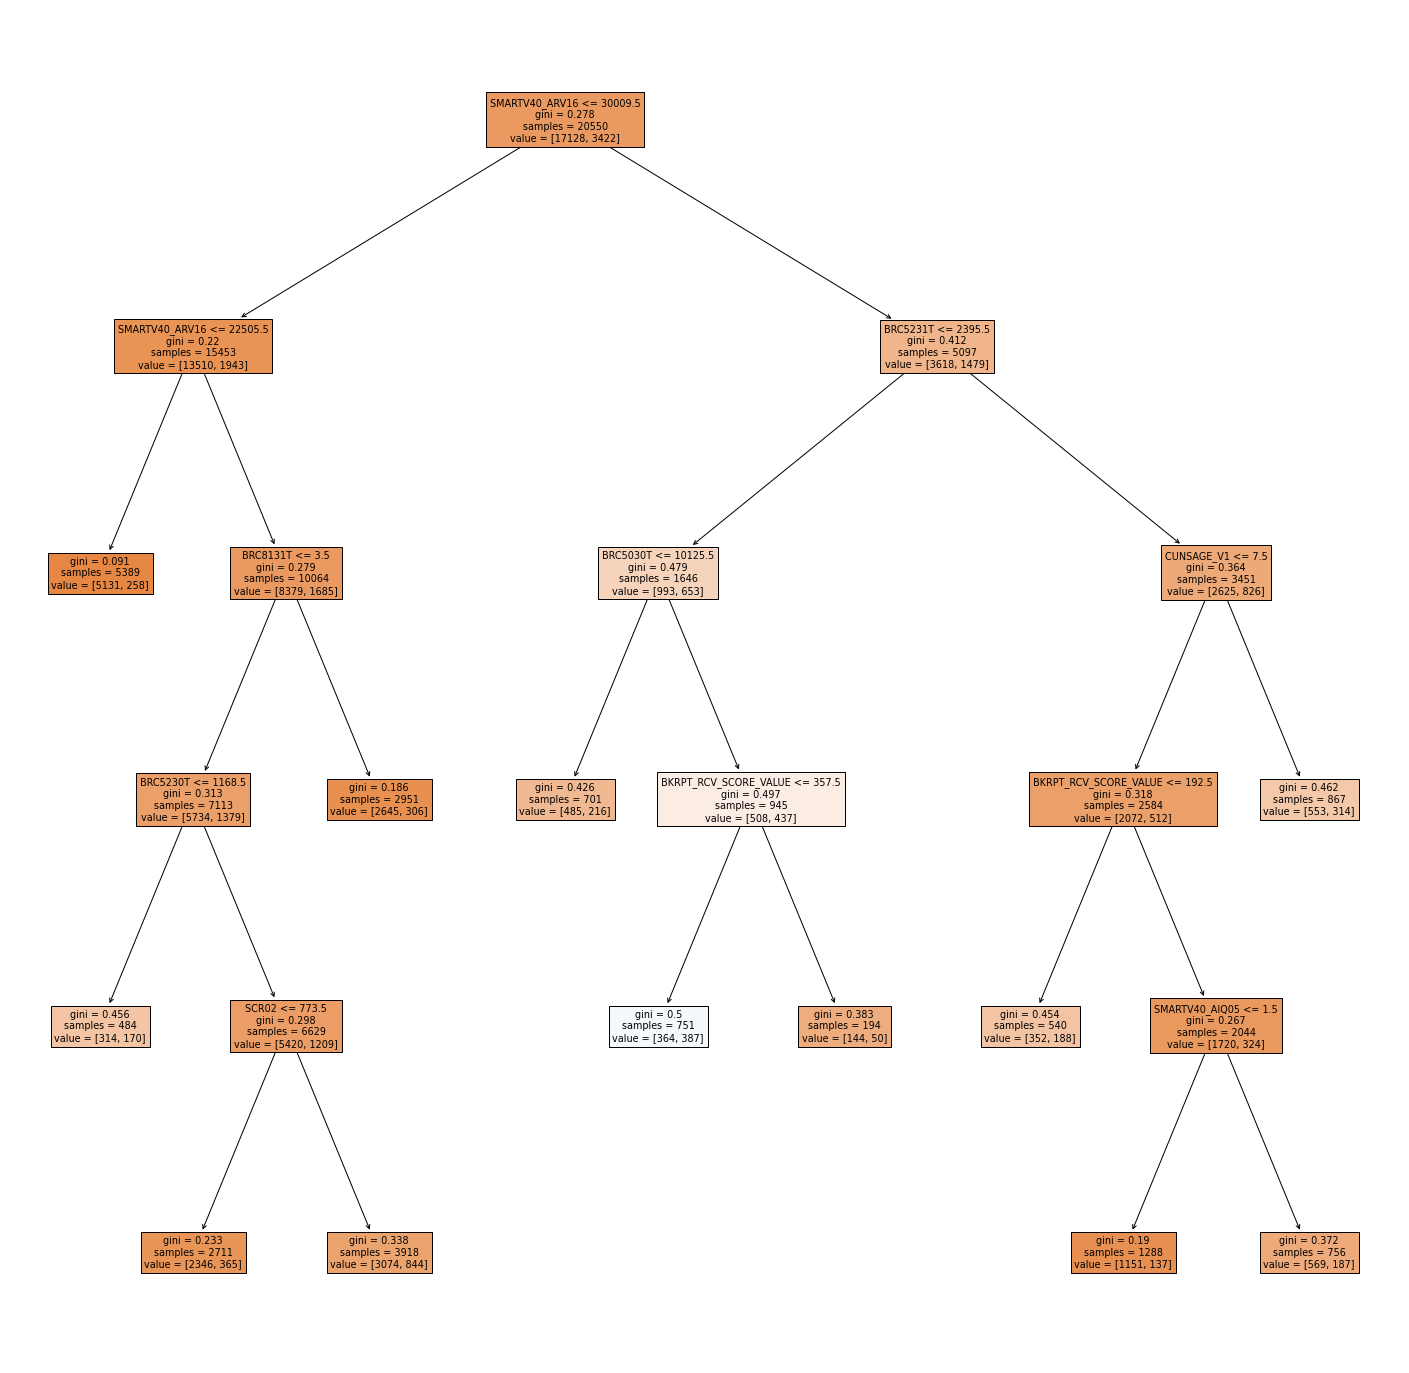

In [112]:
plt.figure(figsize=(25, 25))
plot_tree(DT2, feature_names= X_all.columns, filled=True)
plt.show()

# **Random Forest**

In [117]:
RF1 = RandomForestClassifier(class_weight='balanced',max_depth=8,
                             min_samples_leaf=100, random_state=42).fit(X_train,y_train)
model_performance(X_train, X_test, y_train, y_test, RF1)


ROC AUC Train 0.801
ROC AUC Test 0.728
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     17128
           1       0.35      0.72      0.47      3422

    accuracy                           0.73     20550
   macro avg       0.64      0.73      0.64     20550
weighted avg       0.83      0.73      0.76     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      5722
           1       0.29      0.63      0.40      1129

    accuracy                           0.69      6851
   macro avg       0.60      0.67      0.60      6851
weighted avg       0.80      0.69      0.73      6851

-------------------------


In [194]:
param_rf = {'max_depth': range(4, 9),
            'max_leaf_nodes': range(8, 15), 
            'min_samples_split': np.arange(750, 1300, 120), 
            'min_samples_leaf': np.arange(75, 300, 40)
            }

RT_gs = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_estimators=75, max_features=20),
                     param_grid=param_rf, scoring="neg_log_loss", cv=5, n_jobs=-1, verbose=1)
RT_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 90.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 112.9min
[Parallel(n_jobs=-1)]: Done 5250 out of 5250 | elapsed: 121.7min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=20, n_estimators=75,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 9),
                         'max_leaf_nodes': range(8, 15),
                         'min_samples_leaf': array([ 75, 115, 155, 195, 235, 275]),
                         'min_samples_split': array([ 750,  870,  990, 1110, 1230])},
             scoring='neg_log_loss', verbose=1)

In [195]:
print('Best Params:', RT_gs.best_params_)
print('LogLoss Score:', round(-(RT_gs.best_score_), 3))

Best Params: {'max_depth': 8, 'max_leaf_nodes': 14, 'min_samples_leaf': 115, 'min_samples_split': 750}
LogLoss Score: 0.41


In [202]:
RF2 = RandomForestClassifier(random_state=42, n_estimators=75, max_features=20, 
                             **RT_gs.best_params_).fit(X_train,y_train)
model_performance(X_train, X_test, y_train, y_test, RF2)


ROC AUC Train 0.754
ROC AUC Test 0.724
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     17128
           1       0.00      0.00      0.00      3422

    accuracy                           0.83     20550
   macro avg       0.42      0.50      0.45     20550
weighted avg       0.69      0.83      0.76     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5722
           1       0.00      0.00      0.00      1129

    accuracy                           0.84      6851
   macro avg       0.42      0.50      0.46      6851
weighted avg       0.70      0.84      0.76      6851

-------------------------


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [203]:
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=RF2,X=X_all,y=y_all,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned RF 0.73


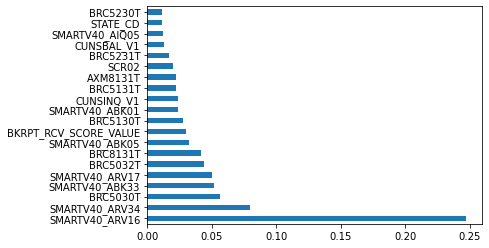

In [216]:
RF_importances = pd.Series(RF2.feature_importances_, index=X_all.columns)
RF_importances.sort_values(ascending=False).nlargest(20).plot(kind='barh')
plt.show()

 99%|===================| 40735/41100 [01:46<00:00]        

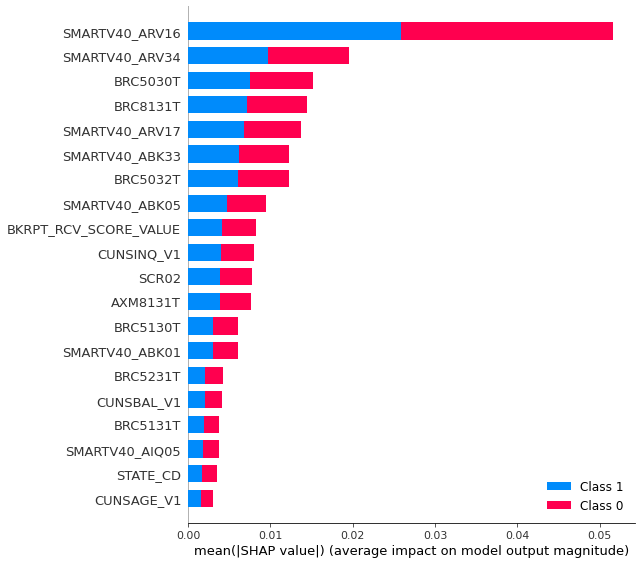

In [217]:
RF_shap_values = shap.TreeExplainer(RF2, X_all).shap_values(X_train)
shap.summary_plot(RF_shap_values, X_train)

# **Gradient Boosting**

In [218]:
GB1 = GradientBoostingClassifier(loss= 'deviance', max_depth = 3, min_samples_split=2, n_estimators=300, 
                                  learning_rate= 0.08, random_state=42, max_leaf_nodes=6).fit(X_train,y_train)

model_performance(X_train, X_test, y_train, y_test, GB1)


ROC AUC Train 0.842
ROC AUC Test 0.744
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     17128
           1       0.79      0.20      0.32      3422

    accuracy                           0.86     20550
   macro avg       0.82      0.59      0.62     20550
weighted avg       0.85      0.86      0.82     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      5722
           1       0.48      0.19      0.28      1129

    accuracy                           0.83      6851
   macro avg       0.67      0.58      0.59      6851
weighted avg       0.80      0.83      0.80      6851

-------------------------


In [267]:
params_gb = {'max_depth': range(3, 6),
             'min_samples_split': np.arange(200, 700, 100),
             'min_samples_leaf': np.arange(10, 70, 15)
             }

GB_gs = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42, max_features=40,
                                                          n_iter_no_change=1, subsample=0.9),
                     param_grid=params_gb, scoring="neg_log_loss", cv=5, n_jobs=-1, verbose=1)

GB_gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.9min finished


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features=40,
                                                  n_iter_no_change=1,
                                                  random_state=42,
                                                  subsample=0.9),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 6),
                         'min_samples_leaf': array([10, 25, 40, 55]),
                         'min_samples_split': array([200, 300, 400, 500, 600])},
             scoring='neg_log_loss', verbose=1)

In [268]:
print('Best Params:', GB_gs.best_params_)
print('LogLoss Score:', round(-(GB_gs.best_score_), 3))

Best Params: {'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 600}
LogLoss Score: 0.391


In [269]:
GB2 = GradientBoostingClassifier(random_state=42, max_features=40, n_iter_no_change=1, 
                                 **GB_gs.best_params_).fit(X_train, y_train)

model_performance(X_train, X_test, y_train, y_test, GB2)


ROC AUC Train 0.816
ROC AUC Test 0.748
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17128
           1       0.76      0.11      0.19      3422

    accuracy                           0.85     20550
   macro avg       0.80      0.55      0.55     20550
weighted avg       0.83      0.85      0.79     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5722
           1       0.60      0.10      0.18      1129

    accuracy                           0.84      6851
   macro avg       0.72      0.55      0.54      6851
weighted avg       0.81      0.84      0.79      6851

-------------------------


In [270]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=GB2,X=X_all,y=y_all,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned GB 0.76


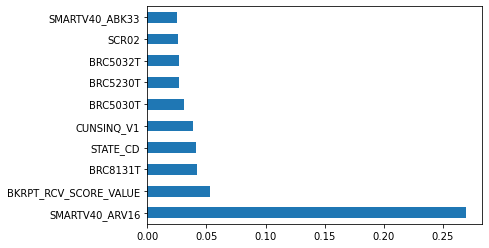

In [271]:
GB_importances = pd.Series(GB2.feature_importances_, index=X_all.columns)
GB_importances.nlargest(10).plot(kind='barh')
plt.show()

 96%|=================== | 19772/20550 [00:24<00:00]       

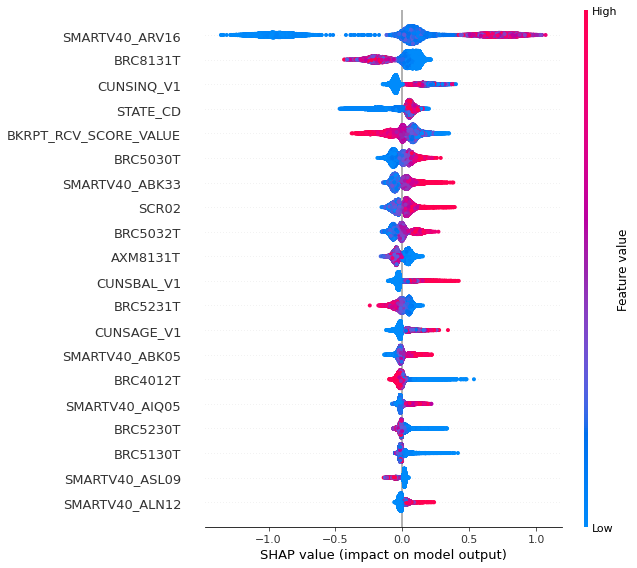

In [272]:
GB_shap_values = shap.TreeExplainer(GB2, X_all).shap_values(X_train)
shap.summary_plot(GB_shap_values, X_train)

# **Final Model**

In [321]:
GB_best_params = {'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 600}

In [437]:
GBFM = GradientBoostingClassifier(random_state=42, max_features=40, n_iter_no_change=1, 
                                  subsample=0.9,**GB_best_params).fit(X_train, y_train)

model_performance(X_train, X_test, y_train, y_test, GBFM)


ROC AUC Train 0.817
ROC AUC Test 0.751
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17128
           1       0.76      0.10      0.18      3422

    accuracy                           0.84     20550
   macro avg       0.80      0.55      0.55     20550
weighted avg       0.83      0.84      0.79     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5722
           1       0.55      0.09      0.16      1129

    accuracy                           0.84      6851
   macro avg       0.70      0.54      0.53      6851
weighted avg       0.80      0.84      0.79      6851

-------------------------


In [435]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=GBFM,X=X_all,y=y_all,cv=5, scoring="roc_auc")).round(3))

Mean 5-fold ROC AUC score for Tuned GB 0.758


# **Model Interpretation**

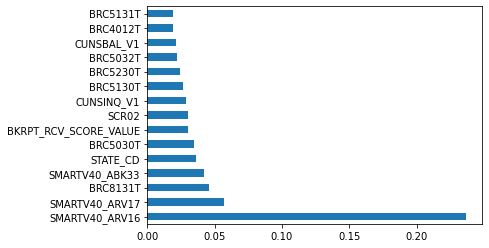

In [439]:
feat_importances = pd.Series(GBFM.feature_importances_, index=X_all.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

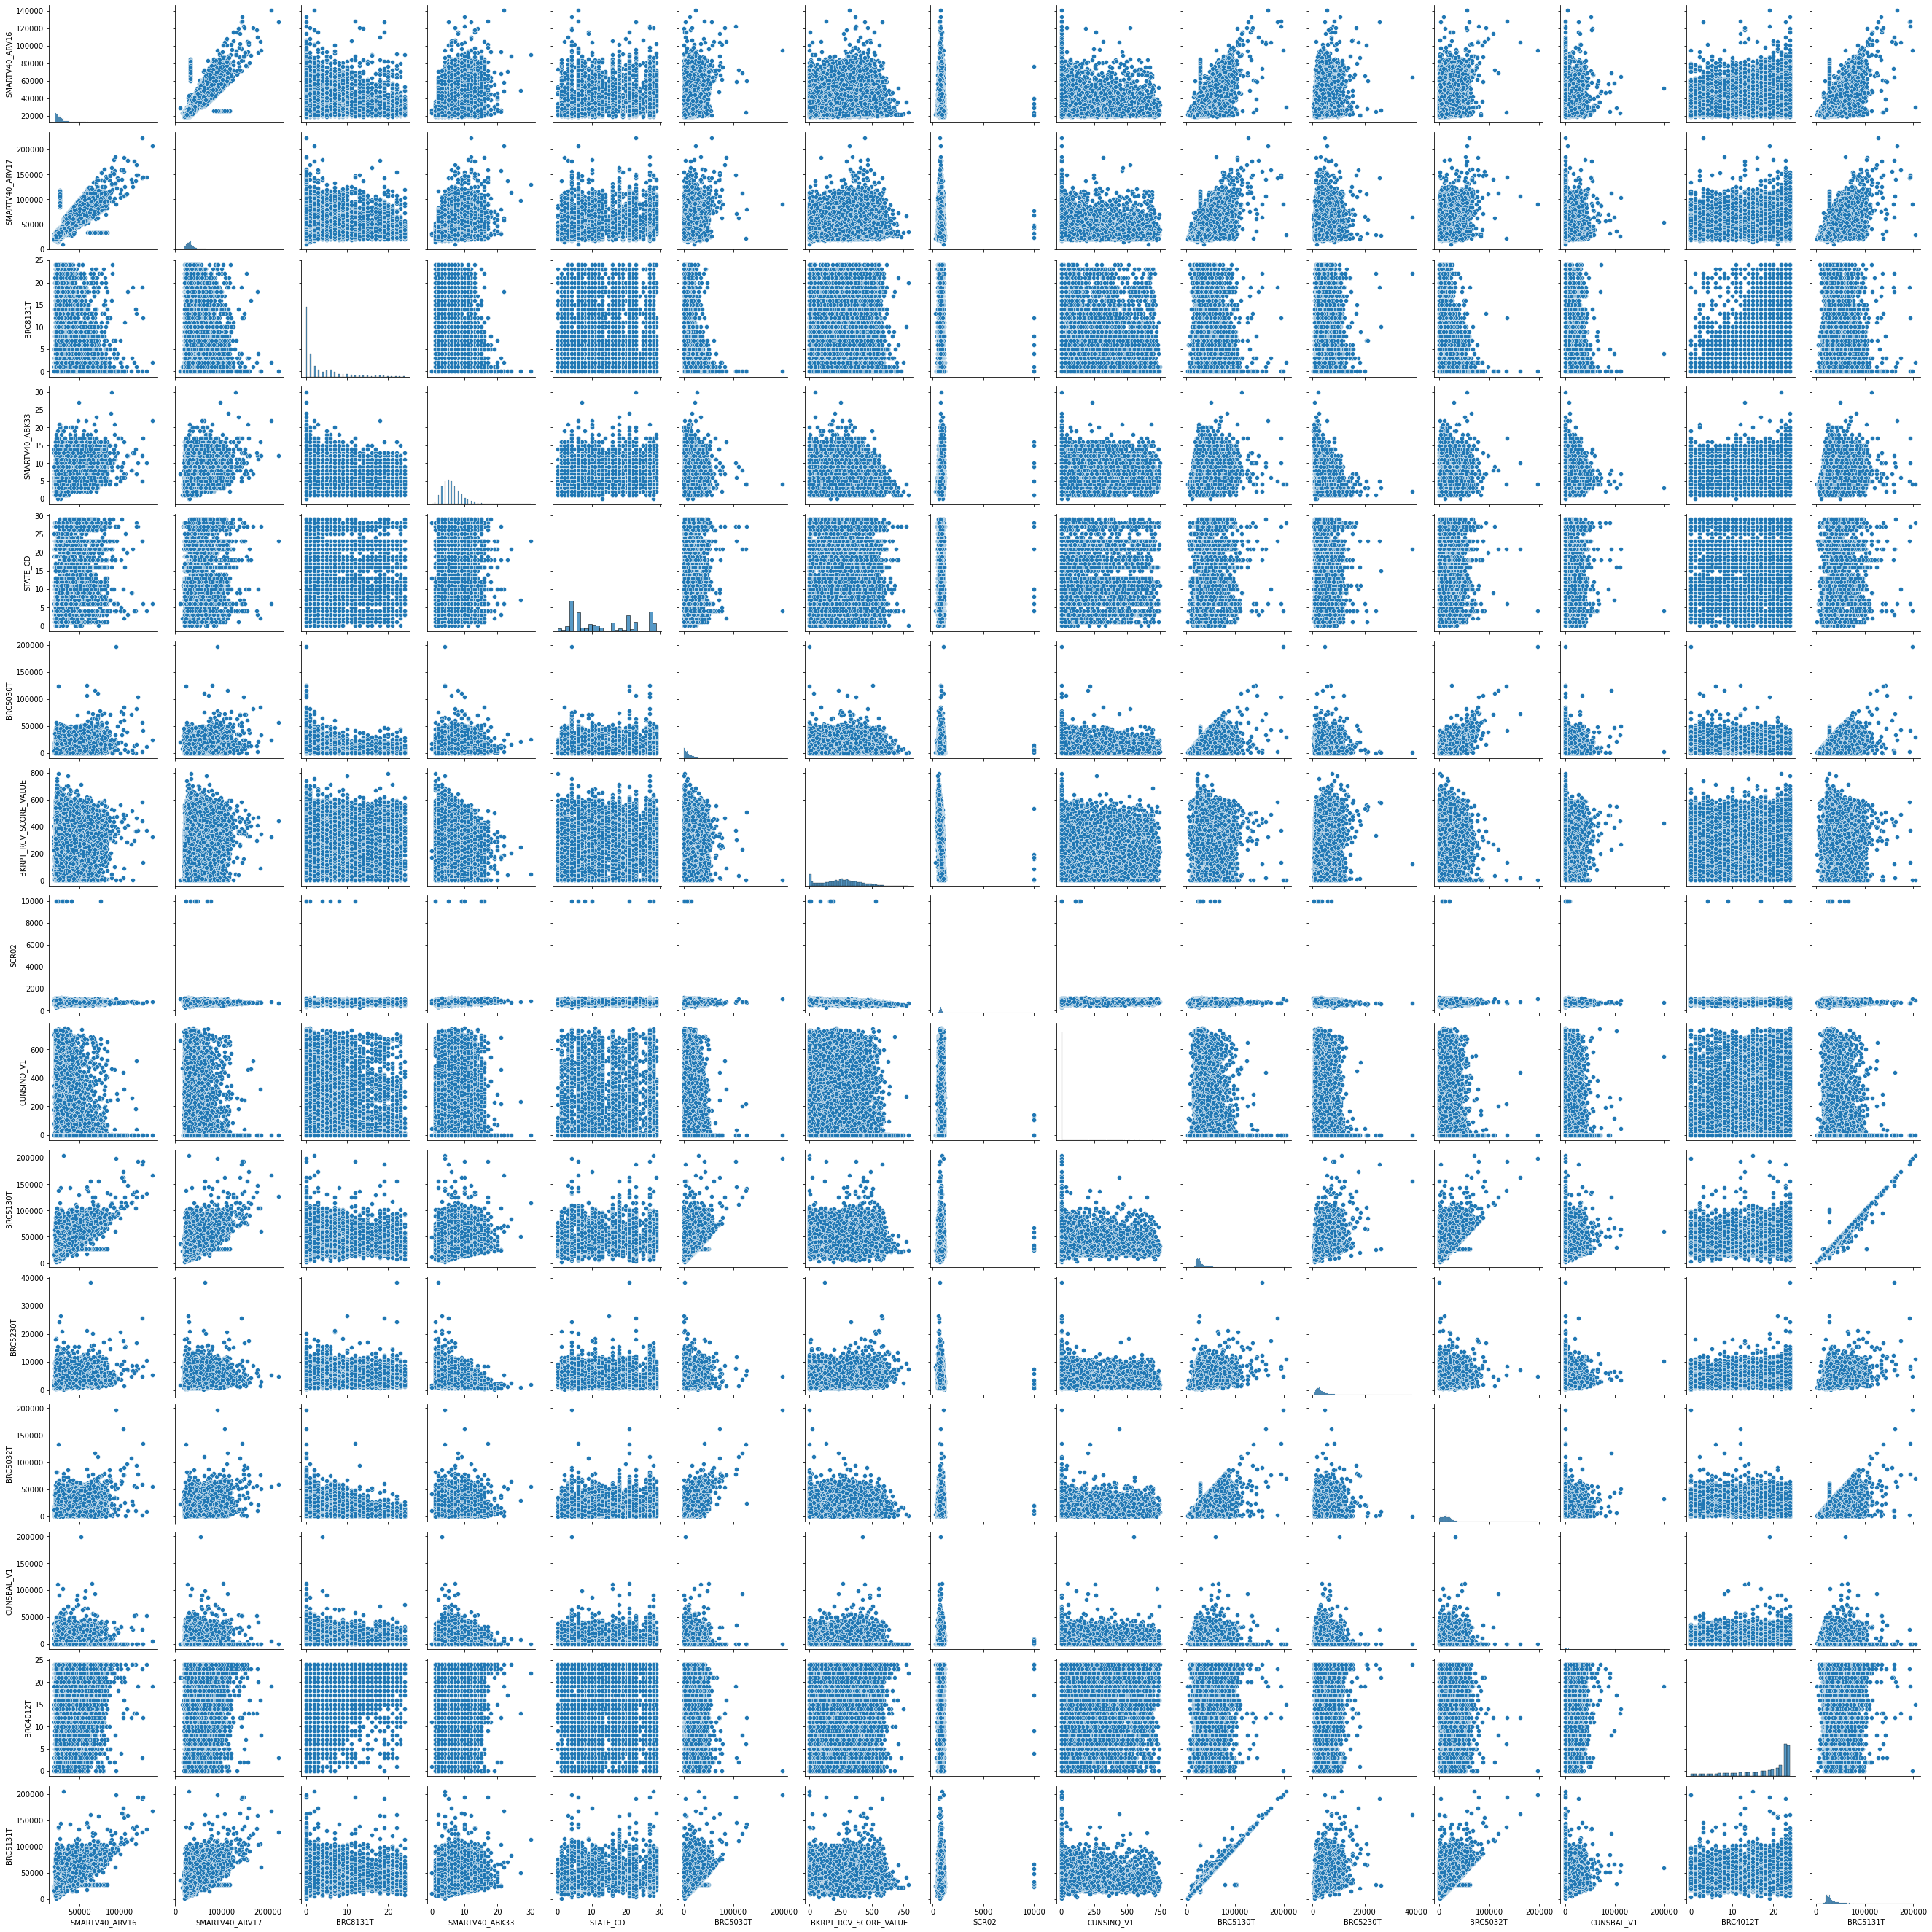

In [443]:
sns.pairplot(X_all[feat_importances.nlargest(15).index])
plt.show()

# **ROC Curve**

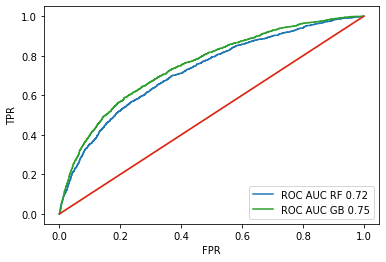

In [446]:
FPR, TPR, thresholds = roc_curve(y_test, RF2.predict_proba(X_test)[:,1])
plt.plot(FPR, TPR, label=f"ROC AUC RF {roc_auc_score(y_test,RF2.predict_proba(X_test)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")

FPR, TPR, thresholds = roc_curve(y_test, GBFM.predict_proba(X_test)[:,1])
plt.plot(FPR, TPR, label=f"ROC AUC GB {roc_auc_score(y_test,GBFM.predict_proba(X_test)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# **Gain Curve**

Random Forest


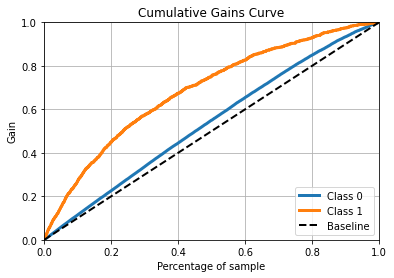


Gradient Boosting Final


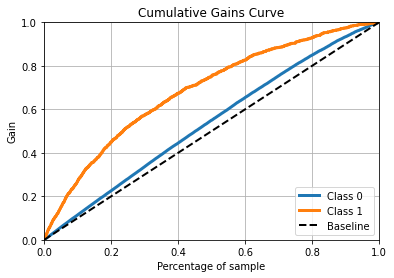

In [450]:
print('Random Forest')
skplt.metrics.plot_cumulative_gain(y_test,RF2.predict_proba(X_test))
plt.show()
print('\nGradient Boosting Final')
skplt.metrics.plot_cumulative_gain(y_test,RF2.predict_proba(X_test))
plt.show()

# **Lift Curve**

Random Forest


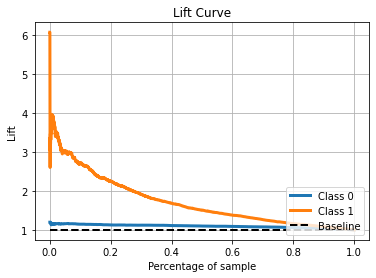


Gradient Boosting Final


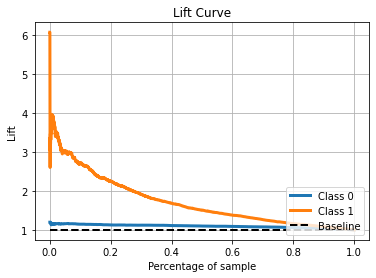

In [451]:
print('Random Forest')
skplt.metrics.plot_lift_curve(y_test,RF2.predict_proba(X_test))
plt.show()
print('\nGradient Boosting Final')
skplt.metrics.plot_lift_curve(y_test,RF2.predict_proba(X_test))
plt.show()

# Alternative models

In [10]:
# Setting up API token, endpoint path
dr.Client(config_path='./drconfig.yaml')
project = dr.Project.start(data, project_name='Email Marketing (median-clean)',
                           autopilot_on=False, autopilot_with_feature_discovery=True,
                           feature_discovery_supervised_feature_reduction=True)

project.set_target(target='RESPONSE_FLAG', metric='LogLoss', positive_class=1, 
                   worker_count=4,  mode='quick')

In [32]:
# Make predictions on your data
pred_dataset = project.upload_dataset(X_test)
DRM = project.recommended_model()
pred_job = DRM.request_predictions(pred_dataset.id)
predictions = pred_job.get_result_when_complete()
predictions_vs_actual = pd.concat([y_test.reset_index(),
                        predictions['positive_probability']], axis=1).set_index('index')

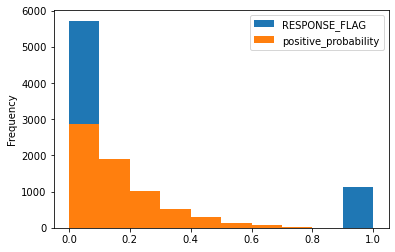

ROC AUC Test: 0.752


In [45]:
predictions_vs_actual.plot(kind='hist')
plt.show()
print('ROC AUC Test:', roc_auc_score(predictions_vs_actual['RESPONSE_FLAG'], 
                                    predictions_vs_actual['positive_probability']).round(3))

In [141]:
data = pd.concat([y_train, X_train], axis=1)

dr.Client(config_path='./drconfig.yaml')
project = dr.Project.start(data, project_name='Email Marketing (autoclean)',
                           autopilot_on=False, target='RESPONSE_FLAG',
                           metric='LogLoss', positive_class=1, worker_count=4,
                           autopilot_with_feature_discovery=True,
                           feature_discovery_supervised_feature_reduction=True)

project.start_autopilot(project.get_association_featurelists()['featurelists'][0]['featurelist_id'], 
                        mode='quick')

In [294]:
# Making predictions on the data
pred_dataset = project.upload_dataset(X_test)
DRM = project.recommended_model()
pred_job = DRM.request_predictions(pred_dataset.id)
predictions = pred_job.get_result_when_complete()
predictions_vs_actual = pd.concat([y_test.reset_index(),
                        predictions['positive_probability']], axis=1).set_index('index')

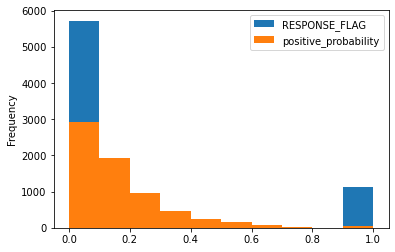

ROC AUC Test: 0.789


In [295]:
predictions_vs_actual.plot(kind='hist')
plt.show()
print('ROC AUC Test:', roc_auc_score(predictions_vs_actual['RESPONSE_FLAG'], 
                                    predictions_vs_actual['positive_probability']).round(3))

In [154]:
params_alt_gb = {'max_depth': range(3, 6),
                 'min_samples_split': np.arange(200, 700, 100),
                 'min_samples_leaf': np.arange(10, 70, 15)
                 }

altGB_gs = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42, max_features=40, n_iter_no_change=1), 
                        param_grid=params_alt_gb, scoring="neg_log_loss", cv=5, n_jobs=-1, verbose=1)

altGB_gs.fit(X_train, y_train)
print('Best Params:', altGB_gs.best_params_)
print('LogLoss Score:', round(-(altGB_gs.best_score_), 3))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


Best Params: {'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 600}
LogLoss Score: 0.38


In [298]:
GB3 = GradientBoostingClassifier(random_state=42, max_features=40, n_iter_no_change=1, 
                                 **altGB_gs.best_params_).fit(X_train, y_train)

model_performance(X_train, X_test, y_train, y_test, GB3)
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=GB3, X=X_all, y=y_all, cv=5, 
                                                                       scoring="roc_auc")).round(2))


ROC AUC Train 0.817
ROC AUC Test 0.774
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     17128
           1       0.80      0.13      0.22      3422

    accuracy                           0.85     20550
   macro avg       0.83      0.56      0.57     20550
weighted avg       0.84      0.85      0.80     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5722
           1       0.70      0.11      0.19      1129

    accuracy                           0.85      6851
   macro avg       0.77      0.55      0.55      6851
weighted avg       0.82      0.85      0.80      6851

-------------------------
Mean 5-fold ROC AUC score for Tuned GB 0.78


In [299]:
XGB1 = XGBClassifier(use_label_encoder=False).fit(X_train, y_train, eval_metric='logloss', 
                                                  eval_set =[(X_test, y_test)], early_stopping_rounds=10, 
                                                 verbose=False)
model_performance(X_train, X_test, y_train, y_test, XGB1)


ROC AUC Train 0.9
ROC AUC Test 0.777
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     17128
           1       0.90      0.31      0.46      3422

    accuracy                           0.88     20550
   macro avg       0.89      0.65      0.70     20550
weighted avg       0.88      0.88      0.85     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      5722
           1       0.62      0.20      0.30      1129

    accuracy                           0.85      6851
   macro avg       0.74      0.59      0.61      6851
weighted avg       0.82      0.85      0.81      6851

-------------------------


In [301]:
params_xgb = {'max_depth': range(2, 7),
              'gamma': range(8, 20, 4),
              'reg_lambda': range(5, 20, 4) 
             }
xgb_main_params = {'n_estimators':125, 'learning_rate': 0.1, 'use_label_encoder': False, 
               'random_state': 42, 'scale_pos_weight': 1, 'colsample_bytree':0.25, 
               'subsample':0.45, 'min_child_weight': 15,'n_jobs': -1}

XGB_gs = GridSearchCV(estimator=XGBClassifier(**xgb_main_params), 
                      param_grid=params_xgb, scoring="neg_log_loss", cv=5, n_jobs=-1, verbose=1)

XGB_gs.fit(X_train, y_train, eval_metric='logloss', eval_set =[(X_test, y_test)],
             early_stopping_rounds=10, verbose=False)

print('Best Params:', XGB_gs.best_params_)
print('LogLoss Score:', round(-(XGB_gs.best_score_), 3))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.3min finished


Best Params: {'gamma': 8, 'max_depth': 4, 'reg_lambda': 5}
LogLoss Score: 0.379


In [346]:
xgb2_params = {'n_estimators':130, 'learning_rate': 0.1, 'use_label_encoder': False, 
               'random_state': 42, 'scale_pos_weight': 1, 'colsample_bytree':0.25, 
               'subsample':0.45, 'min_child_weight': 20, 'max_depth': 4, 'gamma': 10, 
               'reg_lambda': 3, 'n_jobs': -1}
xgb2_fit_params = {'eval_metric':'logloss', 'eval_set': [(X_test, y_test)], 
                   'early_stopping_rounds':10, 'verbose': False}

XGB2 = XGBClassifier(**xgb2_params).fit(X_train, y_train, **xgb2_fit_params)

model_performance(X_train, X_test, y_train, y_test, XGB2)
print("AUC 5-fold:",np.mean(cross_val_score(estimator=XGB2, X=X_all, y=y_all, cv=5, scoring="roc_auc",
                                        n_jobs=-1)).round(4))


ROC AUC Train 0.809
ROC AUC Test 0.783
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     17128
           1       0.70      0.15      0.25      3422

    accuracy                           0.85     20550
   macro avg       0.77      0.57      0.58     20550
weighted avg       0.83      0.85      0.80     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5722
           1       0.64      0.15      0.24      1129

    accuracy                           0.85      6851
   macro avg       0.75      0.57      0.58      6851
weighted avg       0.82      0.85      0.80      6851

-------------------------
AUC 5-fold: 0.779


# Alternative models with pipelines

In [22]:
# Importing the data
dataset = pd.read_csv('./data/email_marketing.csv')

# Setting up variables
target = 'RESPONSE_FLAG'
X = dataset.drop(target, axis=1)
y = dataset[target]

# Splittind data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Performing some preprocessing
# numeric transformations 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
    ('scaler', StandardScaler())])

# categorical transformations
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OrdinalEncoder', OrdinalEncoder())])

# entire pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

# Main Model
xgb3_params = {'n_estimators':200, 'colsample_bylevel':0.5, 'colsample_bytree': 0.89, 
               'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1,
               'max_delta_step': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1,
               'gamma': 1.0, 'scale_pos_weight': 1.0, 'subsample':1.0,
               'use_label_encoder': False, 'random_state': 42, 'n_jobs': -1
              }

XGB3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(**xgb3_params))])
X_transformed = preprocessor.fit_transform(X_test)

In [23]:
xgb3_fit_params = {'eval_metric':'logloss', 'eval_set': [(preprocessor.transform(X_test), y_test)], 
                   'early_stopping_rounds':10, 'verbose': False}
xgb3_fit_params = {'classifier__' + str(key): val for key, val in xgb3_fit_params.items()}

XGB3.fit(X_train, y_train, **xgb3_fit_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd15eed9640>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OrdinalEnc...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0.0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.0, reg_lambda=1,
                               scale_pos_weight=1.0, subsample=1.0,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [10]:
model_performance(X_train, X_test, y_train, y_test, XGB3)
print("AUC 5-fold:",np.mean(cross_val_score(estimator=XGB3, X=X, y=y, cv=5, scoring="roc_auc",
                                        n_jobs=-1)).round(4))


ROC AUC Train 0.914
ROC AUC Test 0.777
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     17128
           1       0.98      0.29      0.44      3422

    accuracy                           0.88     20550
   macro avg       0.93      0.64      0.69     20550
weighted avg       0.89      0.88      0.85     20550

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5722
           1       0.67      0.12      0.21      1129

    accuracy                           0.85      6851
   macro avg       0.76      0.56      0.56      6851
weighted avg       0.82      0.85      0.80      6851

-------------------------
AUC 5-fold: 0.783


In [28]:
pxgb_params = {'n_estimators': 200, 'learning_rate': 0.05,
               'min_child_weight': 1, 'reg_lambda': 1,
               'gamma': 1.0, 'subsample': 1.0,
               'use_label_encoder': False, 'random_state': 42, 'n_jobs': -1
               }

pxgb_fit_params = {'classifier__' + str(key): val for key, val in {'eval_metric':'logloss', 
                   'eval_set': [(preprocessor.transform(X_test), y_test)], 
                   'early_stopping_rounds':10, 'verbose': False}.items()}

pxgb_gs_params = {'classifier__' + str(key): val for key, val in {'max_depth': range(4, 8),
                  'colsample_bytree': np.arange(0.1, 1.1, 0.4),
                  'colsample_bylevel': np.arange(0.1, 1.1, 0.4),
                  'subsample': np.arange(0.1, 1.1, 0.4),
                  'min_samples_split': np.arange(200, 700, 100),
                  'min_samples_leaf': np.arange(10, 70, 15)
                  }.items()}

PXBG = Pipeline([('preprocessor', preprocessor),
                 ('classifier', XGBClassifier(**pxgb_params))])


# pxgb_gs = GridSearchCV(estimator=PXBG, param_grid=pxgb_gs_params, scoring="neg_log_loss", 
#                        cv=5, n_jobs=-1, verbose=1)

pxgb_hrs = HalvingRandomSearchCV(estimator=PXBG, param_distributions=pxgb_gs_params, 
                                 scoring="neg_log_loss", factor=3, cv=5, n_jobs=-1, 
                                 random_state=42, verbose=1, resource='n_samples', 
                                 aggressive_elimination=True)

# pxgb_hrs.fit(X_train, y_train, **pxgb_fit_params)
# print('Best Params:', pxgb_hrs.best_params_)
# print('LogLoss Score:', round(-(pxgb_hrs.best_score_), 4))